In [88]:
import sys
import os
import math
import pandas as pd
import numpy as np

from collections import Counter

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from src.tools.google_drive import ensure_data_files


from statsmodels.tsa.seasonal import seasonal_decompose


# Windows 사용자용
plt.rcParams['font.family'] = 'Malgun Gothic'


parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))  
sys.path.append(parent_dir)

print(f"추가된 경로: {parent_dir}")

data_paths = ensure_data_files()


추가된 경로: c:\Users\LEEYS\Desktop\쩝쩝LAB2\yamyam-lab
기존 data가 존재합니다. 파일 경로를 반환합니다.


### Data Load 및 Join

In [29]:
df_review = pd.read_csv(data_paths["review"], index_col=0)
df_diner = pd.read_csv(data_paths["diner"], index_col=0)
df_reviewer  = pd.read_csv(data_paths["reviewer"], index_col=0)
df_category = pd.read_csv(data_paths["category"], index_col=0)
df_weather = pd.read_csv(data_paths["weather"], encoding='euc-kr')

C:\Users\LEEYS\AppData\Local\Temp\ipykernel_29100\3064111770.py:2: DtypeWarning:

Columns (5,14) have mixed types. Specify dtype option on import or set low_memory=False.



In [31]:
print(f"데이터 추출: {len(df_review):,}")
print(f"데이터 추출: {len(df_diner):,}")
print(f"데이터 추출: {len(df_reviewer):,}")
print(f"데이터 추출: {len(df_category):,}")
print(f"데이터 추출: {len(df_weather):,}")


데이터 추출: 2,287,474
데이터 추출: 233,098
데이터 추출: 668,134
데이터 추출: 233,044
데이터 추출: 3,477


In [54]:
column_mapping = {
    '지점명': 'station_name',
    '일시': 'date',
    '평균기온(°C)': 'avg_temp',
    '최저기온(°C)': 'min_temp',
    '최고기온(°C)': 'max_temp',
    '강수 계속시간(hr)': 'precip_duration_hr',
    '일강수량(mm)': 'daily_precip_mm',
    '평균 풍속(m/s)': 'avg_wind_speed',
    '최소 상대습도(%)': 'min_humidity',
    '평균 상대습도(%)': 'avg_humidity',
    '평균 증기압(hPa)': 'avg_vapor_pressure',
    '합계 일사량(MJ/m2)': 'total_solar_radiation',
    '일 최심적설(cm)': 'max_snow_depth',
    '평균 전운량(1/10)': 'avg_cloud_cover',
    '평균 지면온도(°C)': 'avg_ground_temp',
    '최저 초상온도(°C)': 'min_surface_temp',
    '기사': 'reporter'
}

df_weather.rename(columns=column_mapping, inplace=True)
df_weather.reset_index(drop=True, inplace=True)

In [55]:
print(f"데이터 추출: {len(df):,}")

데이터 추출: 2,287,474


In [56]:
df_weather['date'] = pd.to_datetime(df_weather['date'])

In [57]:
print(df['reviewer_review_date'].dtype)
print(df_weather['date'].dtype)

datetime64[ns]
datetime64[ns]


In [58]:
df = pd.merge(df_review, df_diner, on='diner_idx', how='left')
df = pd.merge(df, df_reviewer, on='reviewer_id', how='left')
df = pd.merge(df, df_category, on='diner_idx', how='left')


In [59]:
df["reviewer_review_date"] = pd.to_datetime(df['reviewer_review_date'])
df = pd.merge(df, df_weather, left_on='reviewer_review_date', right_on='date', how='inner')

df['reviewer_review_weekday'] = df['reviewer_review_date'].dt.weekday


In [13]:
numeric_df = df.select_dtypes(include=['number'])

In [60]:
df['quarter'] = df['reviewer_review_date'].dt.to_period('Q')
df['quarter'] = df['reviewer_review_date'].dt.quarter.apply(lambda x: x)

In [ ]:
def categorize_precip(mm):
    if mm == 0:
        return 0
    elif mm <= 5:
        return 1
    elif mm <= 20:
        return 2
    elif mm <= 50:
        return 3
    else:
        return 4

In [63]:

precip_category_counter = {}

df['precip_category'] = df['daily_precip_mm'].fillna(0).apply(categorize_precip)

your_counters = []
for label, group in df.groupby('precip_category'):
    your_counters.append(Counter(group['diner_category_large']))

### 1. 강수량에 따른 리뷰 수(비율)

In [18]:

records = []
for level, counter in enumerate(your_counters):
    total_reviews = sum(v for k, v in counter.items() if k is not None and str(k) != 'nan')
    for category, count in counter.items():
        if category is not None and str(category) != 'nan':
            percent = (count / total_reviews) * 100
            records.append({
                'precip_level': f'Level {level}',
                'category': category,
                'count': count,
                'percentage': percent
            })

df_by_rain = pd.DataFrame(records)

In [28]:
import plotly.express as px

fig = px.bar(df_by_rain,
             x='category',
             y='percentage',
             color='precip_level',
             barmode='group',
             title='강수량 구간별 음식 카테고리 비율 (%)',
             labels={'category': '음식 카테고리', 'percentage': '리뷰 비율 (%)', 'precip_level': '강수량 구간'})

fig.update_layout(yaxis_tickformat='.2f')  # 퍼센트 소수점 두 자리로
fig.show()


### 2. 온도별 평균 review score 시각화

In [ ]:
import pandas as pd
import plotly.express as px

In [65]:
weather_summary = df.groupby('avg_temp')['reviewer_review_score'].agg(
    평균평점='mean',
    표준편차='std',
    중앙값='median',
    리뷰수='count'
).reset_index()

fig = px.line(
    weather_summary,
    x='avg_temp',
    y='평균평점',
    markers=True,
    title='평균 기온별 평균 평점 변화',
    hover_data={
        '평균평점': True,
        '표준편차': True,
        '중앙값': True,
        '리뷰수': True,
        'avg_temp': True
    }
)

fig.update_layout(xaxis_title='평균 기온 (°C)', yaxis_title='평균 평점')
fig.show()


### 3. 평균 강수량 별 리뷰 통계계

In [68]:

daily_precip_grouped = df.groupby('daily_precip_mm')['reviewer_review_score'].agg(
    평균평점='mean',
    표준편차='std',
    중앙값='median',
    리뷰수='count'
)

daily_precip_grouped['smooth'] = daily_precip_grouped['평균평점'].rolling(window=5, center=True).mean()
daily_precip_grouped = daily_precip_grouped.reset_index()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=daily_precip_grouped['daily_precip_mm'],
    y=daily_precip_grouped['평균평점'],
    mode='lines+markers',
    name='Original',
    opacity=0.3,
    hovertemplate=
        '강수량: %{x}mm<br>' +
        '평균평점: %{y:.2f}<br>' +
        '표준편차: %{customdata[0]:.2f}<br>' +
        '중앙값: %{customdata[1]:.2f}<br>' +
        '리뷰수: %{customdata[2]}<extra></extra>',
    customdata=daily_precip_grouped[['표준편차', '중앙값', '리뷰수']].values
))

fig.add_trace(go.Scatter(
    x=daily_precip_grouped['daily_precip_mm'],
    y=daily_precip_grouped['smooth'],
    mode='lines',
    name='Smoothed (Moving Avg)',
    line=dict(width=2)
))

fig.update_layout(
    title='강수량별 평균 평점 (이동평균 포함)',
    xaxis_title='일 강수량 (mm)',
    yaxis_title='리뷰 평점',
    width=1200,
    height=600
)

fig.show()


### 4. 평균 습도 별 리뷰 평균

In [70]:

daily_precip_grouped = df.groupby('avg_humidity')['reviewer_review_score'].agg(
    평균평점='mean',
    표준편차='std',
    중앙값='median',
    리뷰수='count'
)

daily_precip_grouped['smooth'] = daily_precip_grouped['평균평점'].rolling(window=5, center=True).mean()
daily_precip_grouped = daily_precip_grouped.reset_index()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=daily_precip_grouped['avg_humidity'],
    y=daily_precip_grouped['평균평점'],
    mode='lines+markers',
    name='Original',
    opacity=0.3,
    hovertemplate=
        '습도: %{x}<br>' +
        '평균평점: %{y:.2f}<br>' +
        '표준편차: %{customdata[0]:.2f}<br>' +
        '중앙값: %{customdata[1]:.2f}<br>' +
        '리뷰수: %{customdata[2]}<extra></extra>',
    customdata=daily_precip_grouped[['표준편차', '중앙값', '리뷰수']].values
))

fig.add_trace(go.Scatter(
    x=daily_precip_grouped['avg_humidity'],
    y=daily_precip_grouped['smooth'],
    mode='lines',
    name='Smoothed (Moving Avg)',
    line=dict(width=2)
))

fig.update_layout(
    title='습도별 평균 평점 (이동평균 포함)',
    xaxis_title='일 습도',
    yaxis_title='리뷰 평점',
    width=1200,
    height=600
)

fig.show()


### 5. 리뷰 수 시계열 분해

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.



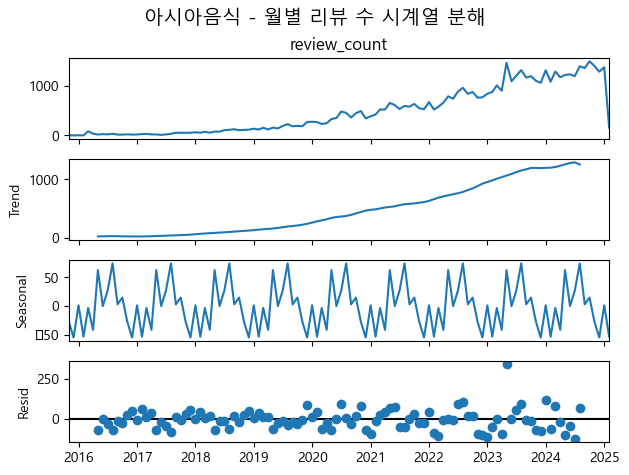

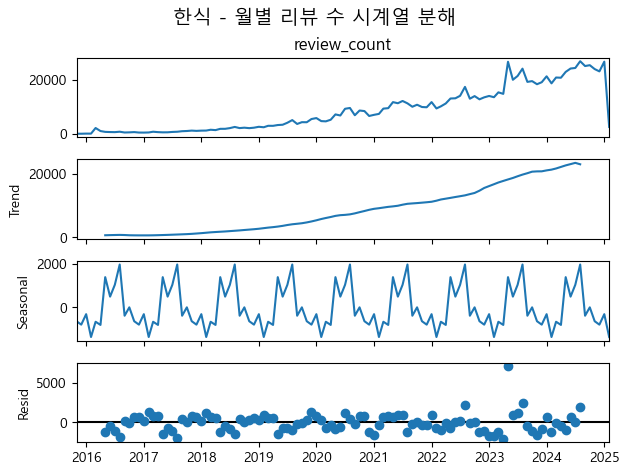

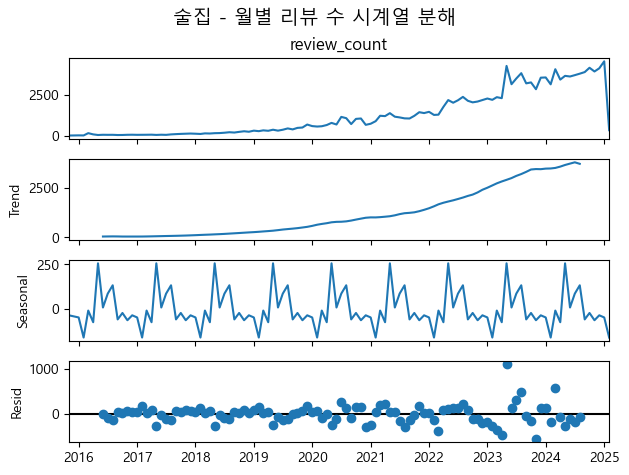

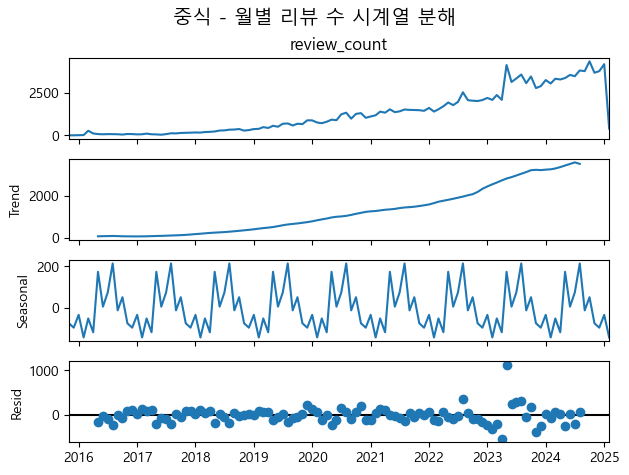

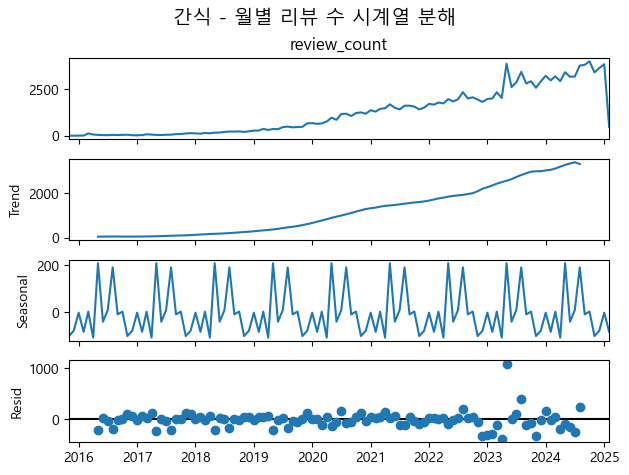

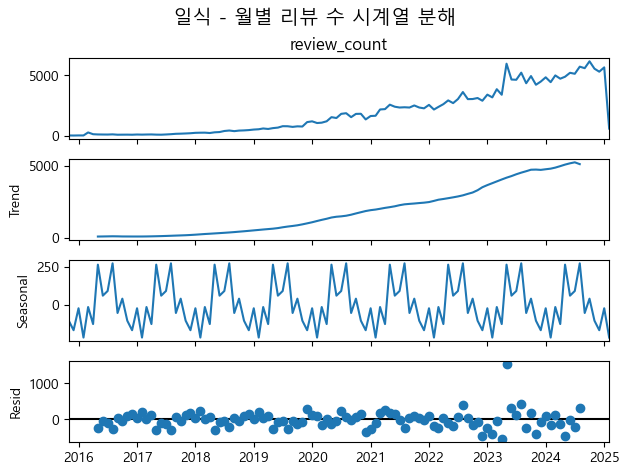

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.



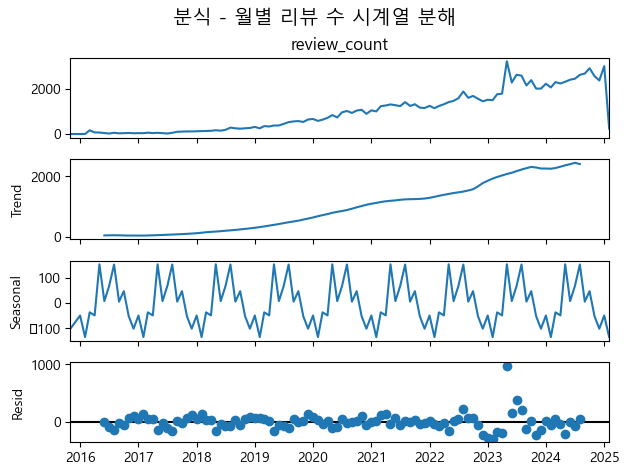

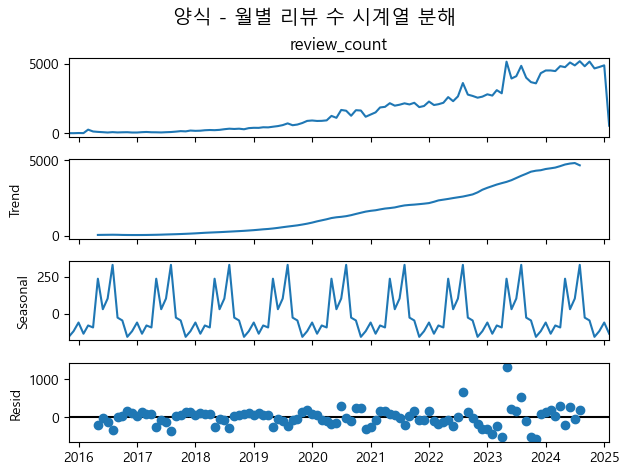

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.



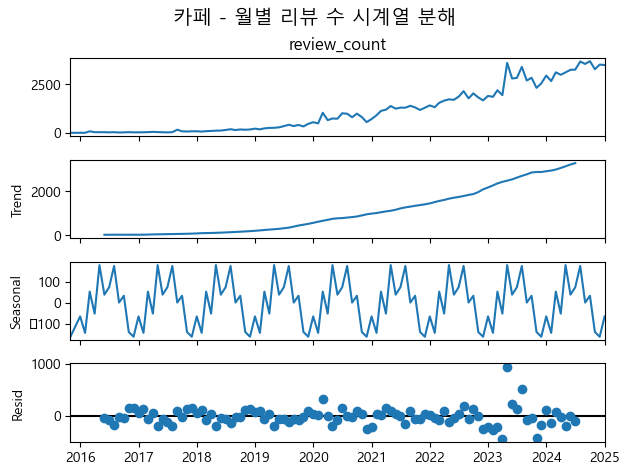

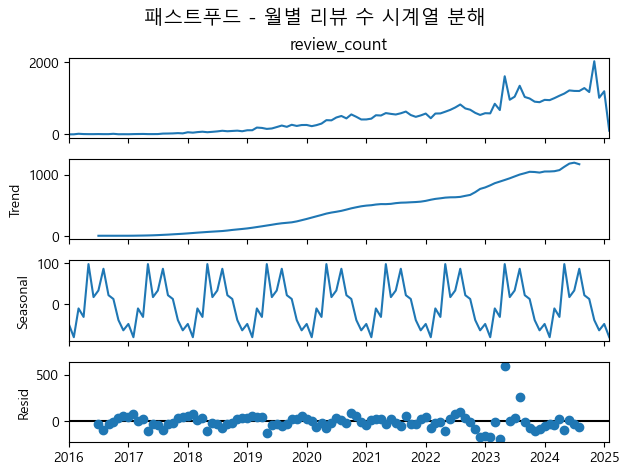

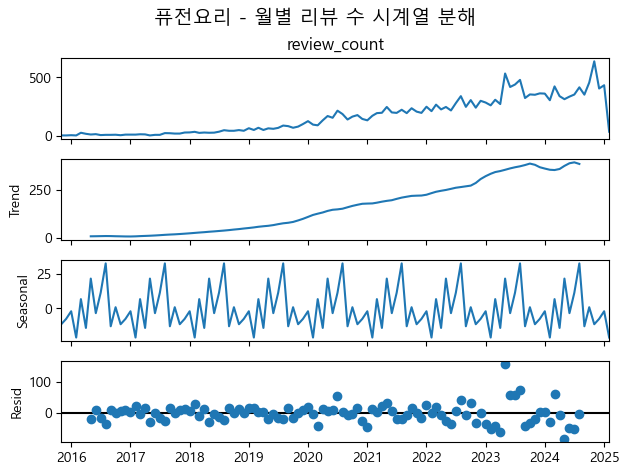

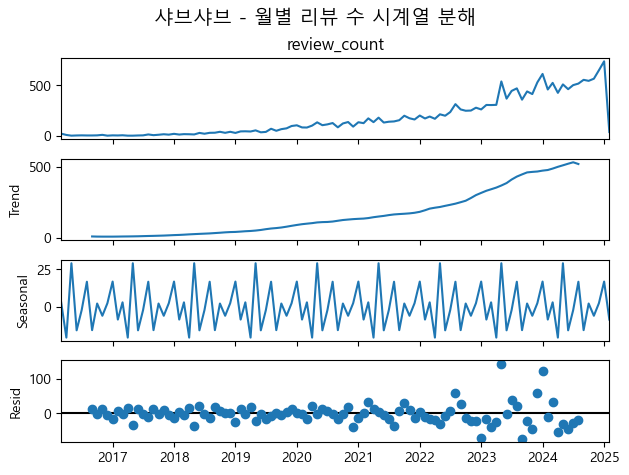

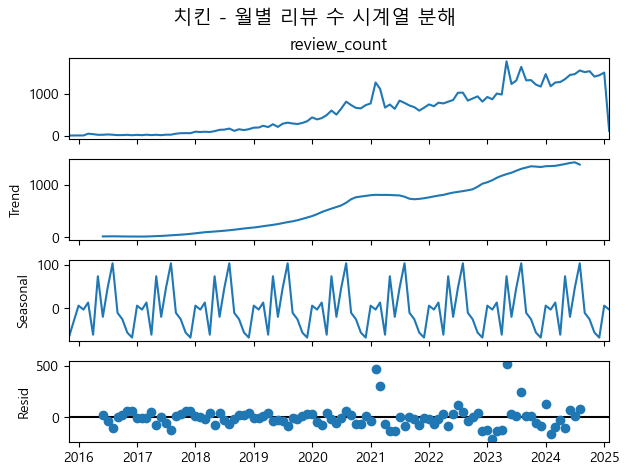

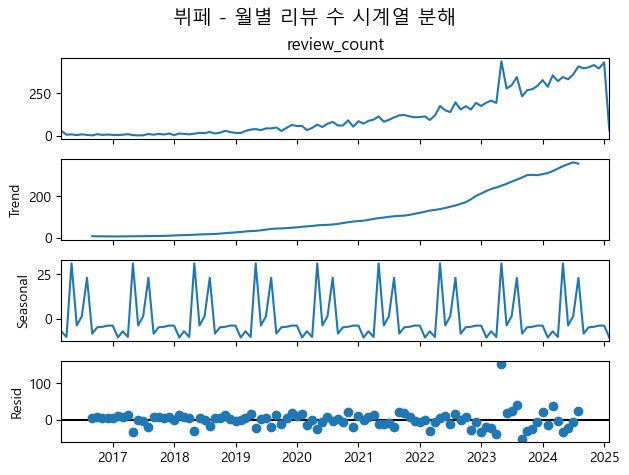

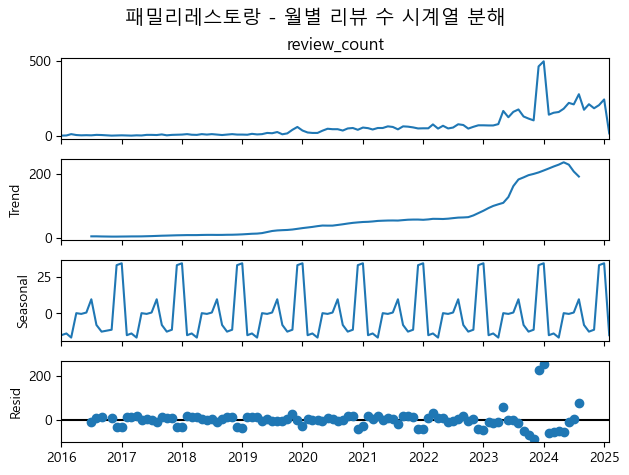

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.



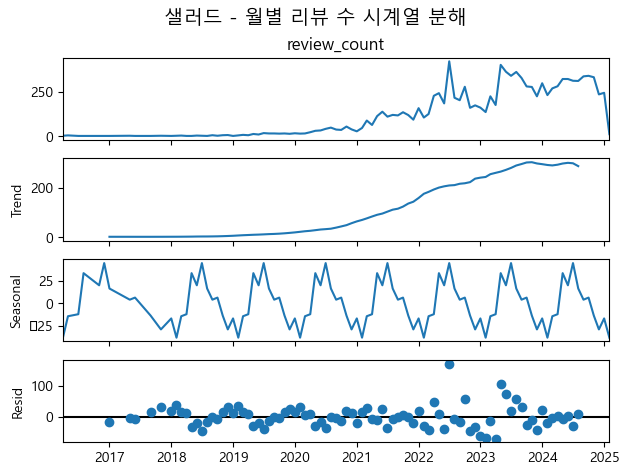

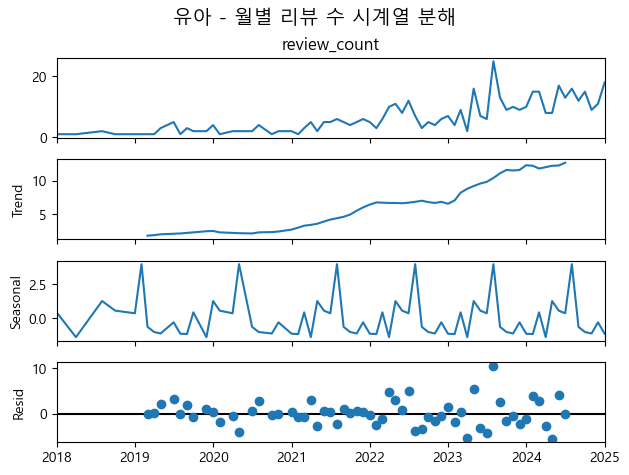

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.



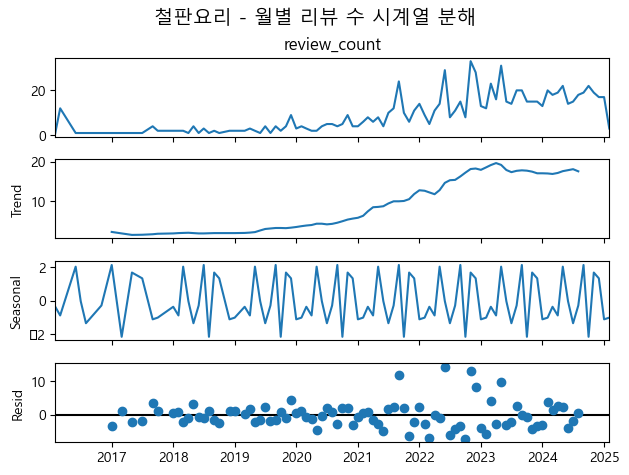

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.



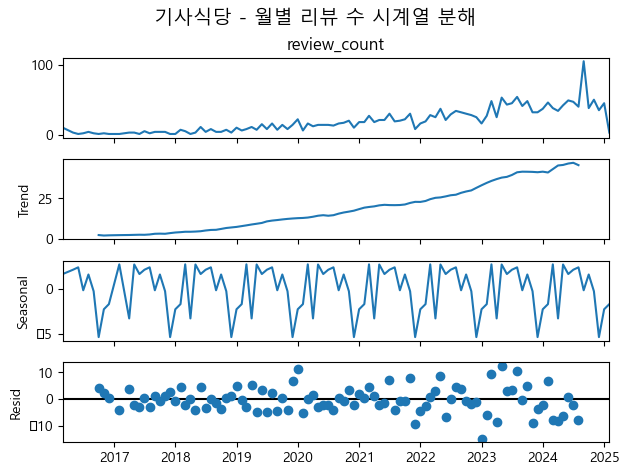

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.



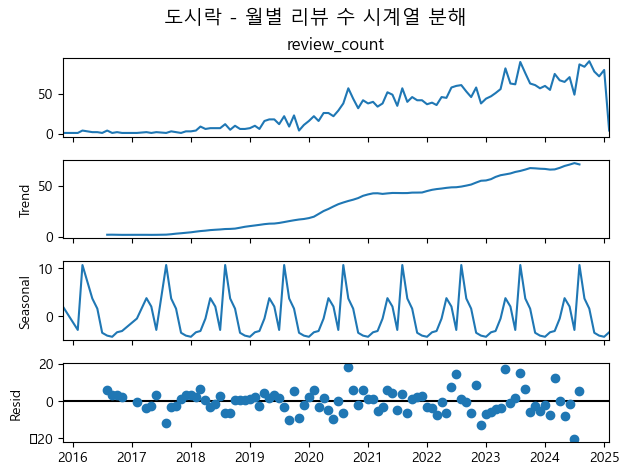

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.



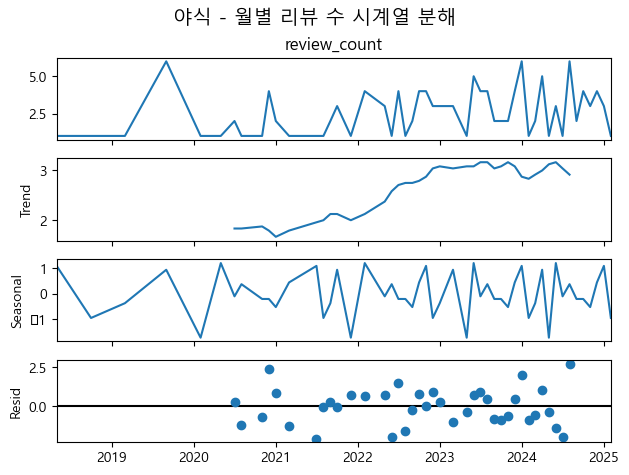

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.



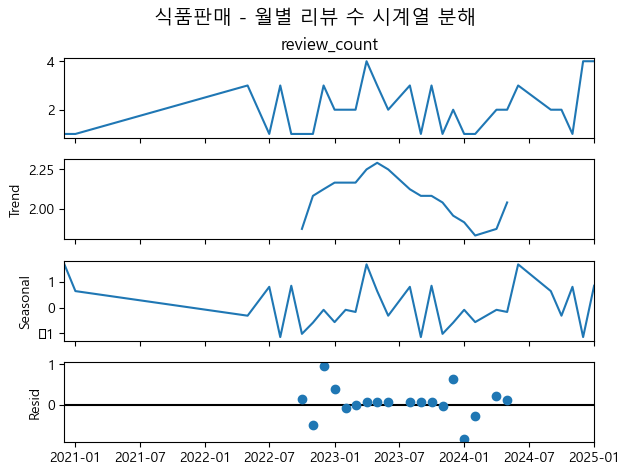

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.



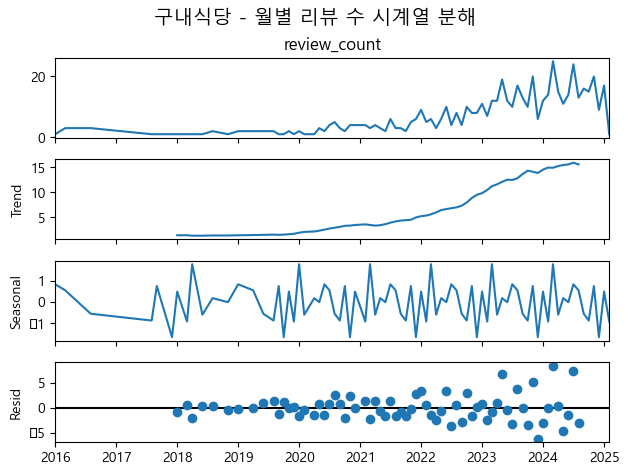

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.



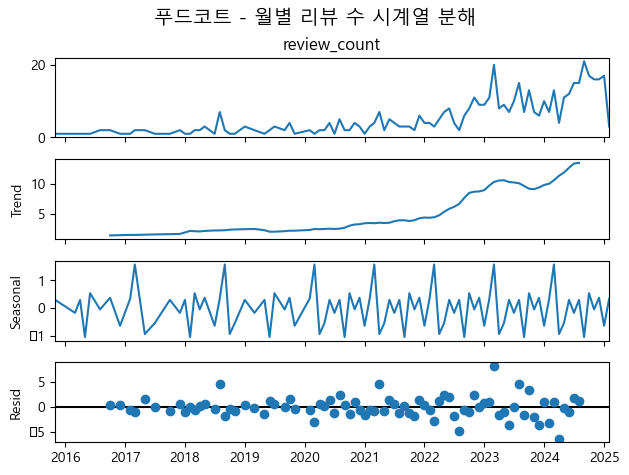

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\statsmodels\tsa\seasonal.py:360: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.

c:\Users\LEEYS\AppData\Local\pypoetry\Cache\virtualenvs\src-WQq5zYiq-py3.11\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.



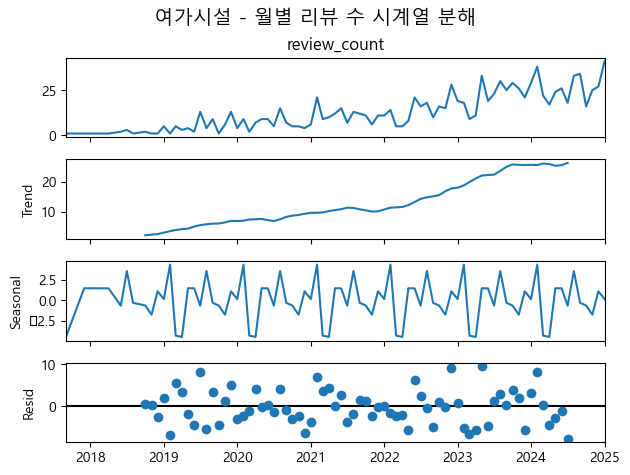

In [72]:

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.to_period('M')

monthly_counts = df.groupby(['diner_category_large', 'month']).size().reset_index(name='review_count')

for cat in df.diner_category_large.unique():
    cat_df = monthly_counts[monthly_counts['diner_category_large'] == cat].copy()
    cat_df['month'] = cat_df['month'].dt.to_timestamp()
    cat_df.set_index('month', inplace=True)

    try:
        result = seasonal_decompose(cat_df['review_count'], model='additive', period=12)
        fig = result.plot()
        plt.suptitle(f'{cat} - 월별 리뷰 수 시계열 분해', fontsize=14)
        plt.subplots_adjust(top=0.88)

        plt.show()
    except:
        continue

### 6. 월별 리뷰 평점 시계열 분해

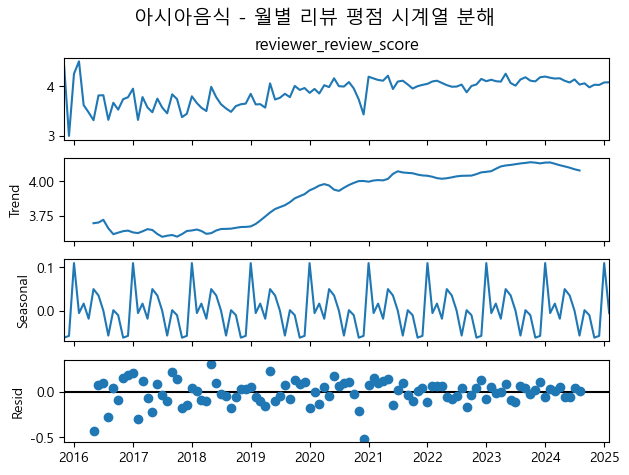

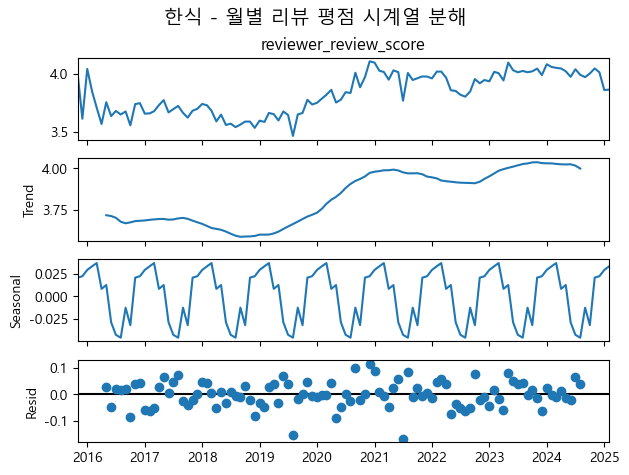

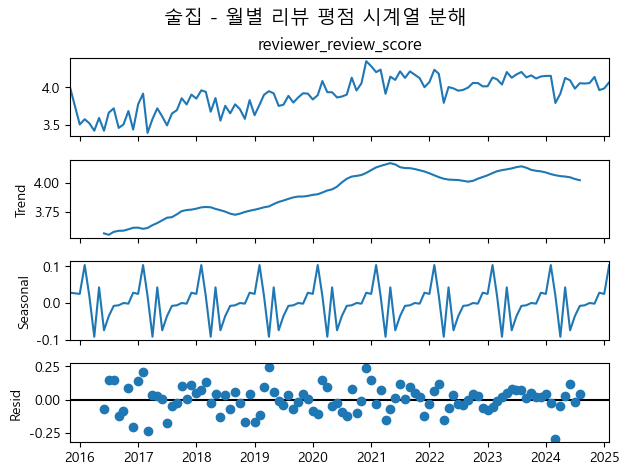

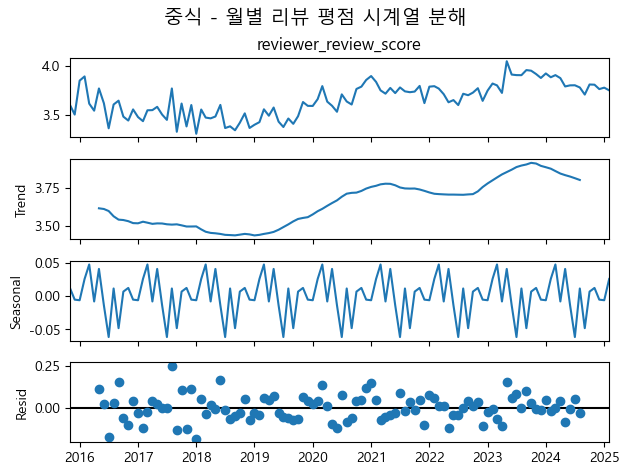

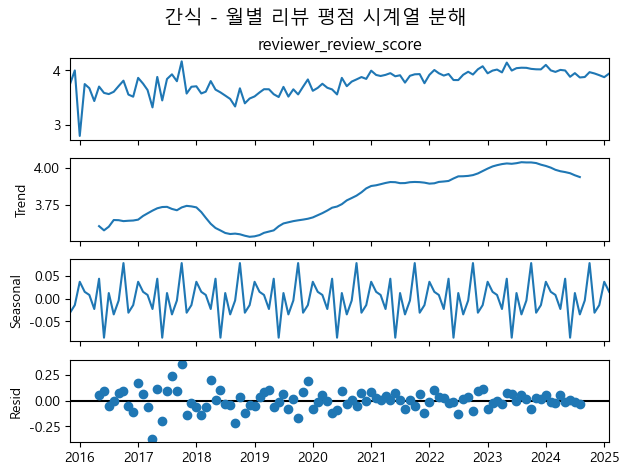

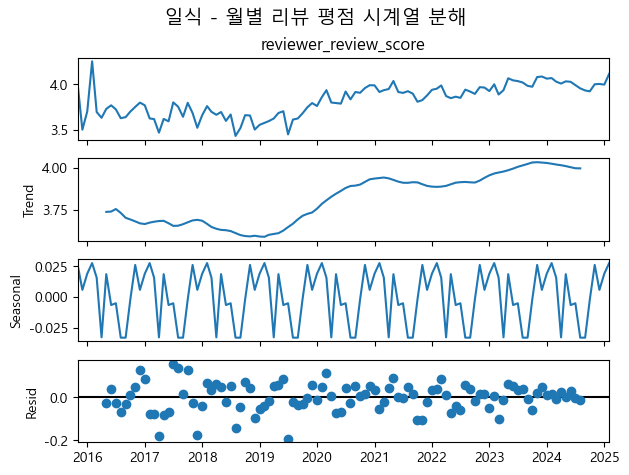

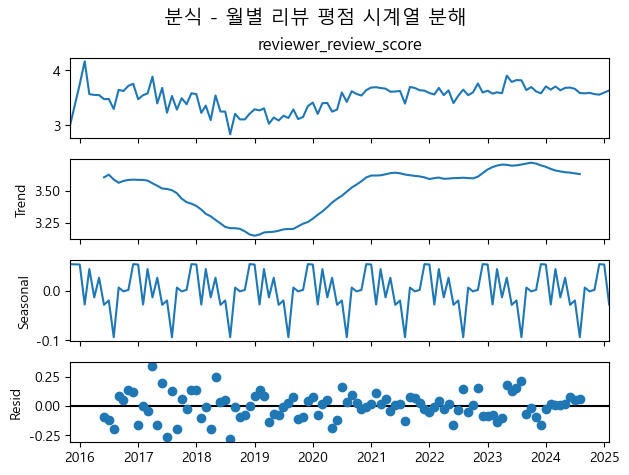

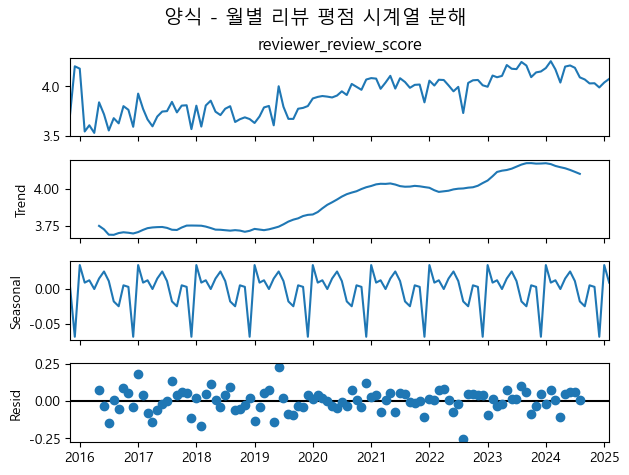

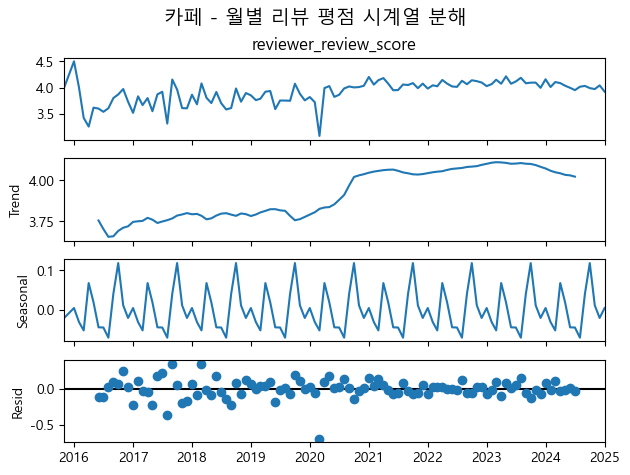

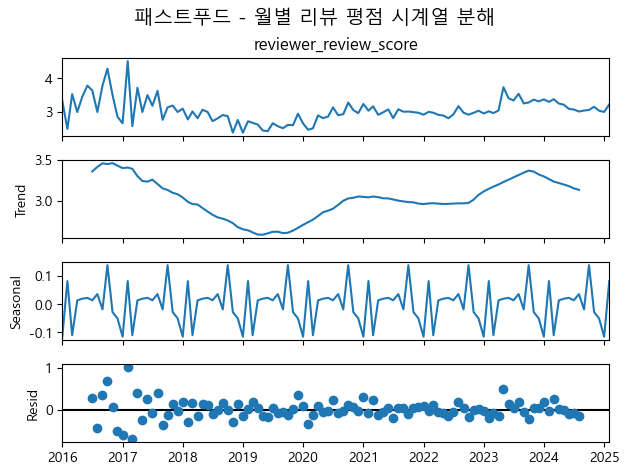

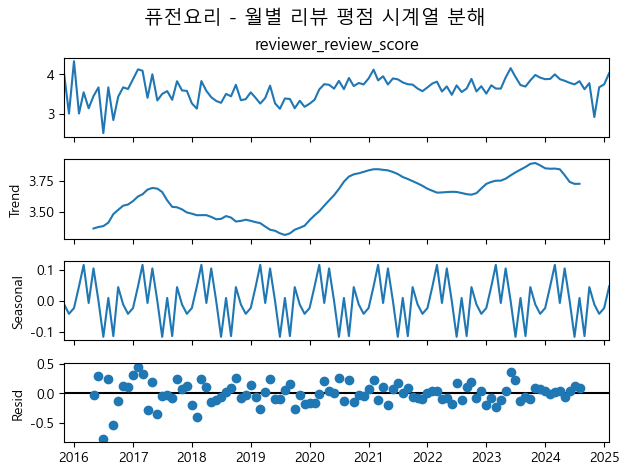

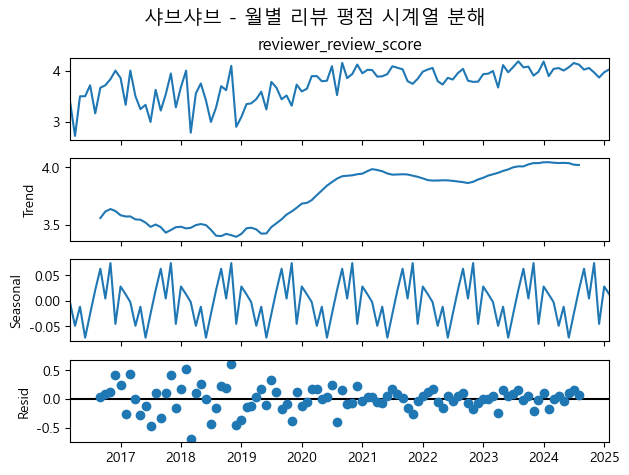

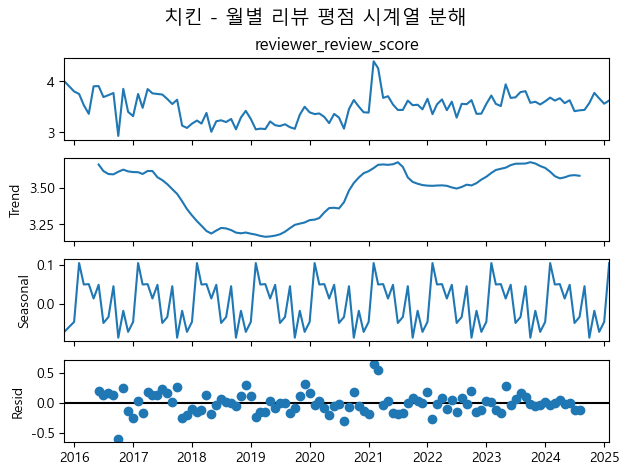

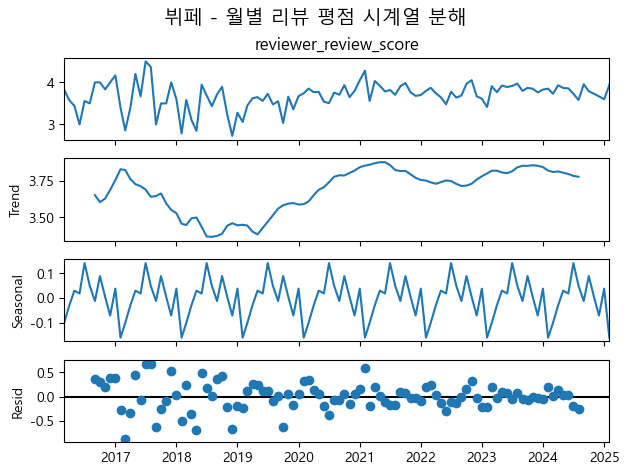

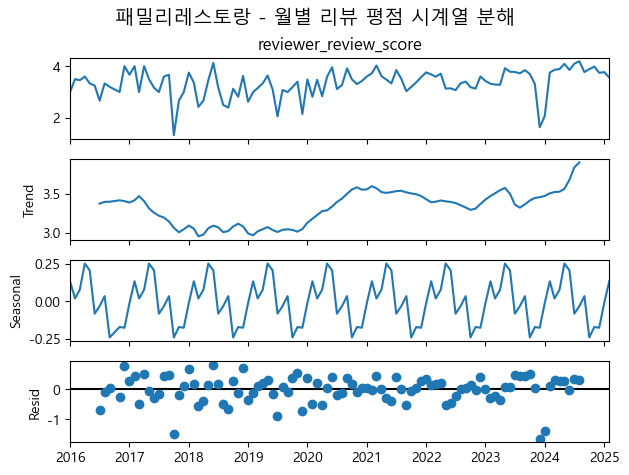

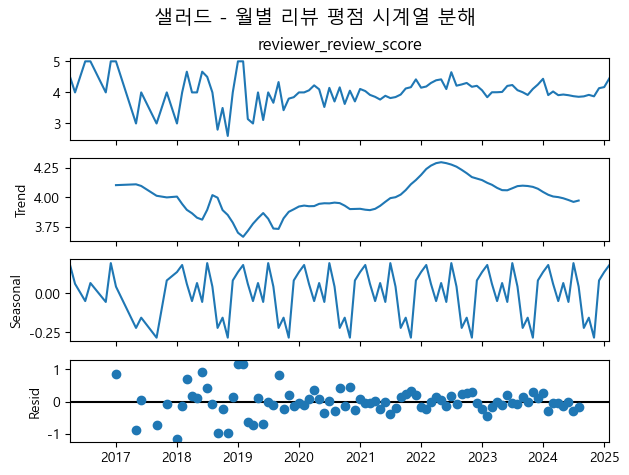

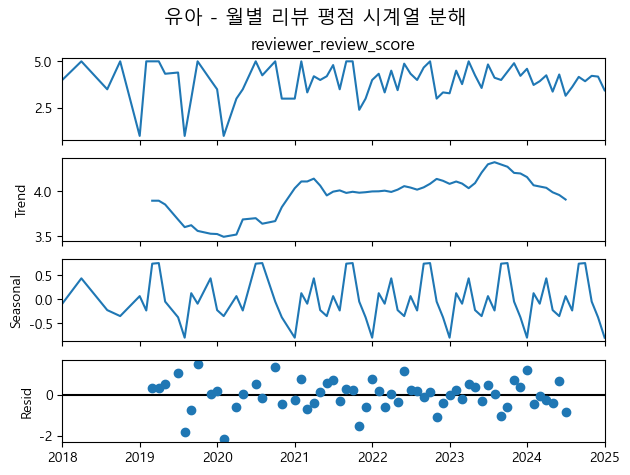

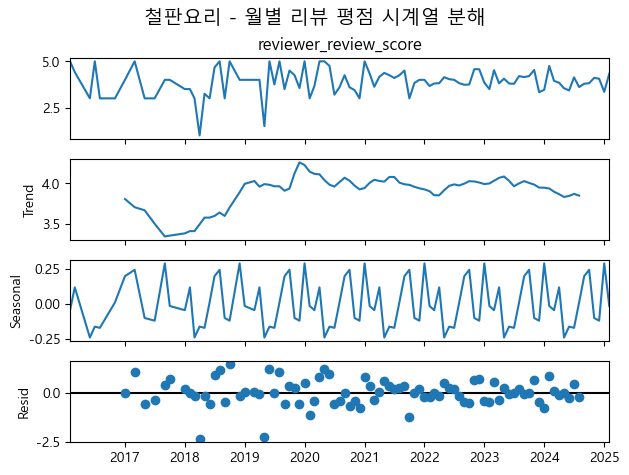

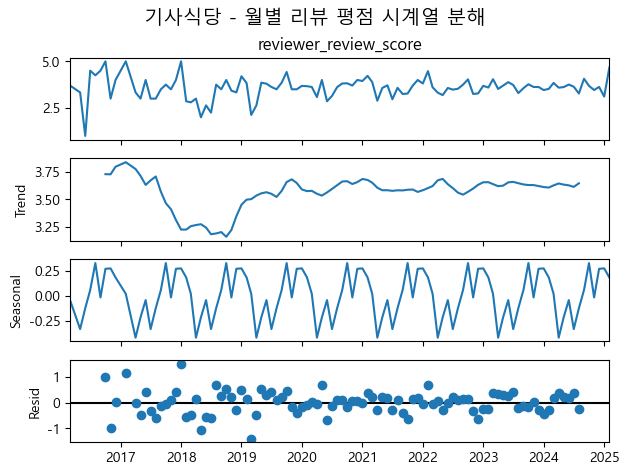

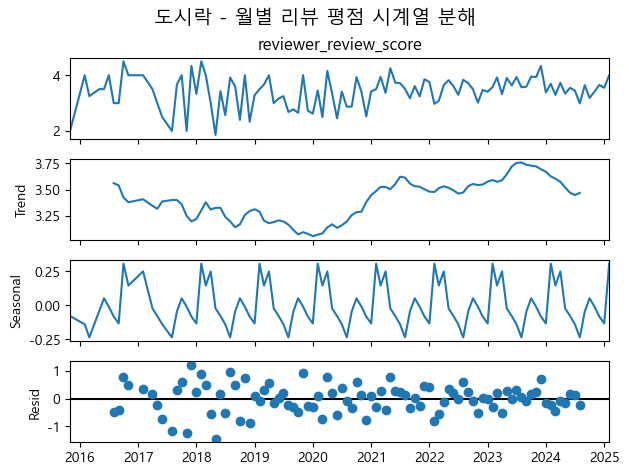

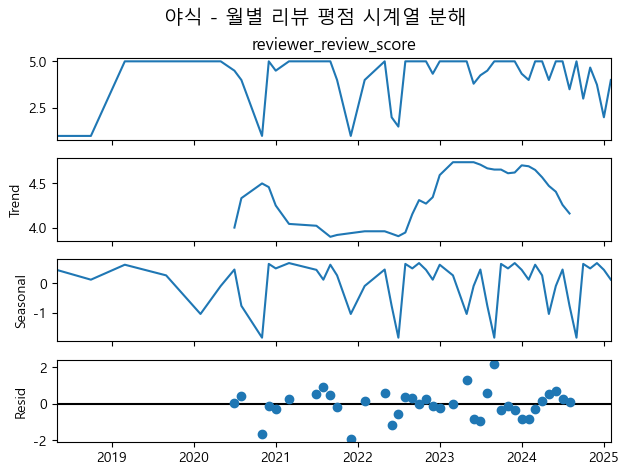

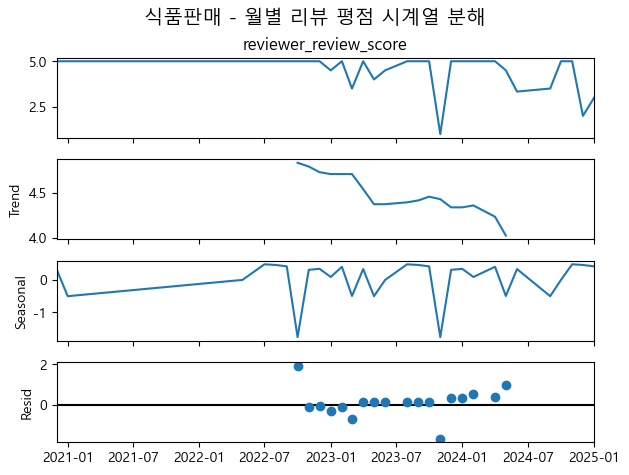

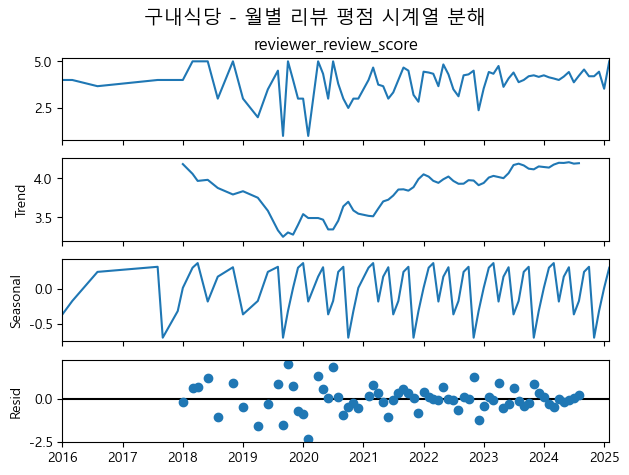

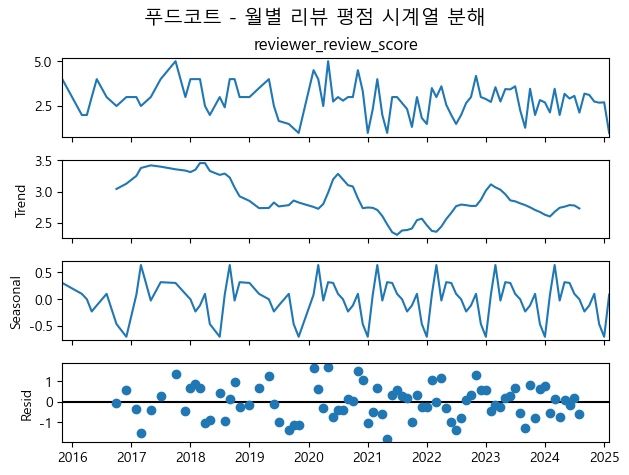

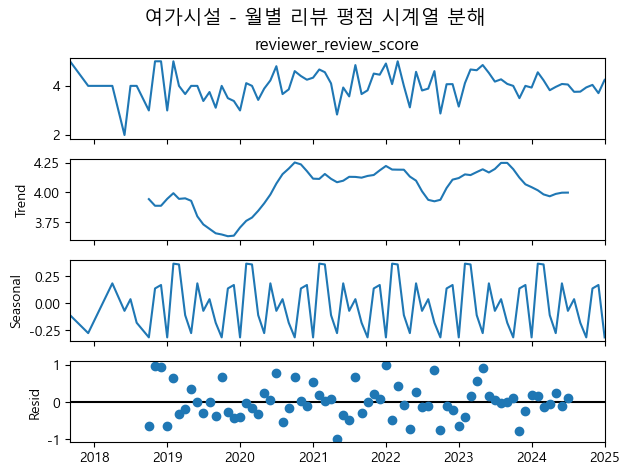

In [ ]:
monthly_avg_scores = df_clean.groupby(['diner_category_large', 'month'])['reviewer_review_score'].mean().reset_index()

for cat in df_clean['diner_category_large'].unique():
    cat_df = monthly_avg_scores[monthly_avg_scores['diner_category_large'] == cat].copy()

    cat_df['month'] = cat_df['month'].dt.to_timestamp()

    cat_df = cat_df.sort_values('month')
    cat_df.set_index('month', inplace=True)

    try:
        result = seasonal_decompose(cat_df['reviewer_review_score'], model='additive', period=12)
        fig = result.plot()
        plt.suptitle(f'{cat} - 월별 리뷰 평점 시계열 분해', fontsize=14)
        plt.subplots_adjust(top=0.88)
        plt.show()
        plt.close()
    except:
        continue


In [327]:
df_weather.columns

Index(['station_name', 'date', 'avg_temp', 'min_temp', 'max_temp',
       'precip_duration_hr', 'daily_precip_mm', 'avg_wind_speed',
       'min_humidity', 'avg_humidity', 'avg_vapor_pressure',
       'total_solar_radiation', 'max_snow_depth', 'avg_cloud_cover',
       'avg_ground_temp', 'min_surface_temp', 'reporter'],
      dtype='object')

In [328]:
monthly_scores

,diner_category_large,month,reviewer_review_score
0,간식,2015-11,3.750000
1,간식,2015-12,4.000000
2,간식,2016-01,2.800000
3,간식,2016-02,3.750000
4,간식,2016-03,3.674797
...,...,...,...
2473,한식,2024-10,4.004121
2474,한식,2024-11,4.048560
2475,한식,2024-12,4.014324
2476,한식,2025-01,3.860993


### 7. 음식 카테고리별 평점 X 날씨 정보 상관관계 (Seasonal)

In [78]:
df_clean = df.dropna(subset=['reviewer_review_score'])

df_clean['month'] = df_clean['date'].dt.to_period('M')
df_weather['month'] = df_weather['date'].dt.to_period('M')

monthly_scores = df_clean.groupby(['diner_category_large', 'month'])['reviewer_review_score'].mean().reset_index()

results = []

for weather in df_weather.columns:
    if weather == 'month': 
        continue

    try:
        monthly_weather = df_weather.groupby('month')[weather].mean().reset_index()
        monthly_weather['month'] = monthly_weather['month'].dt.to_timestamp()

        weather_decomposed = seasonal_decompose(monthly_weather[weather], model='additive', period=12)
        weather_seasonal = weather_decomposed.seasonal[:-3]  

        for cat in df_clean['diner_category_large'].unique():
            cat_df = monthly_scores[monthly_scores['diner_category_large'] == cat].copy()
            cat_df['month'] = cat_df['month'].dt.to_timestamp()
            cat_df = cat_df.sort_values('month')

            try:
                cat_df.set_index('month', inplace=True)
                cat_df['reviewer_review_score'] = cat_df['reviewer_review_score'].interpolate(method='linear')

                result = seasonal_decompose(cat_df['reviewer_review_score'], model='additive', period=12)
                seasonal_score = result.seasonal.reset_index(drop=True)

                seasonal_corr = pd.concat([seasonal_score, weather_seasonal], axis=1).dropna()
                seasonal_corr.columns = ['seasonal_score', 'seasonal_weather']
                corr_value = seasonal_corr.corr(method='spearman').iloc[1, 0]

                results.append({
                    'weather_variable': weather,
                    'category': cat,
                    'seasonal_correlation': round(corr_value, 4)
                })

            except:
                results.append({
                    'weather_variable': weather,
                    'category': cat,
                    'seasonal_correlation': None
                })

    except:
        continue

corr_df = pd.DataFrame(results)

In [80]:
corr_df.dropna(inplace=True)
corr_df = corr_df[corr_df['weather_variable'] != 'date']

In [ ]:
corr_df = corr_df.sort_values('seasonal_correlation').reset_index(drop=True)
corr_df

,weather_variable,category,seasonal_correlation
0,avg_vapor_pressure,한식,-0.8897
1,min_temp,한식,-0.8787
2,min_surface_temp,한식,-0.8787
3,daily_precip_mm,한식,-0.8519
4,avg_temp,한식,-0.8482
...,...,...,...
320,total_solar_radiation,기사식당,0.6575
321,avg_wind_speed,뷔페,0.6713
322,precip_duration_hr,도시락,0.6750
323,avg_cloud_cover,도시락,0.7024


### 8. 날씨 데이터 변환 후 상관관계 (Trend)

In [ ]:
def comfort_score_temp(x, center=20, width=10):
    '''
    입력된 온도 값에 대해 쾌적 점수를 계산합니다. 특정 중심 온도(center)에서 멀어질수록 점수가 낮아지는 가우시안(Gaussian) 형태의 함수를 사용합니다.
    매개변수:
     - x (float 또는 numpy array): 점수를 계산할 온도 값 또는 값들.
     - center (float, 기본값=20): 가장 높은 쾌적 점수(1.0)를 부여할 중심 온도.
     - width (float, 기본값=10): 점수가 중심에서 멀어짐에 따라 감소하는 속도를 조절하는 값. 값이 작을수록 점수 감소가 가파름.
    반환 값: 입력된 온도 값에 해당하는 쾌적 점수 (0.0에서 1.0 사이).
    계산 방식: exp(-((x - center) ** 2) / (2 * (width ** 2)))
    '''
    return np.exp(-((x - center) ** 2) / (2 * (width ** 2)))

def comfort_score_humidity(x, center=55, width=15):
    '''
    입력된 습도 값에 대해 쾌적 점수를 계산. 특정 중심 습도(center)에서 멀어질수록 점수가 낮아지는 가우시안 형태의 함수를 사용.
    매개변수:
     - x (float 또는 numpy array): 점수를 계산할 습도 값 또는 값들.
     - center (float, 기본값=55): 가장 높은 쾌적 점수(1.0)를 부여할 중심 습도.
     - width (float, 기본값=15): 점수가 중심에서 멀어짐에 따라 감소하는 속도를 조절하는 값. 값이 작을수록 점수 감소가 가파름.
    반환 값: 입력된 습도 값에 해당하는 쾌적 점수 (0.0에서 1.0 사이).
    계산 방식: exp(-((x - center) ** 2) / (2 * (width ** 2)))
    '''
    return np.exp(-((x - center) ** 2) / (2 * (width ** 2)))

def inverse_score(x):
    '''
    입력된 값에 대해 반비례 점수를 계산. 입력 값이 클수록 점수가 낮아짐짐.
    매개변수:
     - x (float 또는 numpy array): 점수를 계산할 값 또는 값들. 0 이상의 값을 가정.
    반환 값: 입력된 값에 해당하는 점수 (0.0에서 1.0 사이). 입력 값이 0이면 1.0, 값이 커질수록 0에 수렴.
    계산 방식: 1 / (1 + x)
    '''
    return 1 / (1 + x)  


In [89]:
df_weather['temp_score'] = comfort_score_temp(df_weather['avg_temp'])
df_weather['humidity_score'] = comfort_score_humidity(df_weather['avg_humidity'])
df_weather['precip_score'] = inverse_score(df_weather['daily_precip_mm'])


In [90]:
df_weather['month'] = df_weather['date'].dt.to_period('M')
weather_monthly_scores = df_weather.groupby('month')[
    ['temp_score', 'humidity_score', 'precip_score']
].mean().reset_index()

weather_monthly_scores['month'] = weather_monthly_scores['month'].dt.to_timestamp()
weather_monthly_scores.set_index('month', inplace=True)
weather_monthly_scores = weather_monthly_scores.reset_index(drop=True)[:-3]


In [93]:

for weather in weather_monthly_scores.columns:
    try:
        monthly_humidity_decompose = seasonal_decompose(weather_monthly_scores[weather], model='additive', period=12)
        weather_seasonal = monthly_humidity_decompose.seasonal
        for cat in df_clean['diner_category_large'].unique():
            cat_df = monthly_scores[monthly_scores['diner_category_large'] == cat].copy()
            cat_df['month'] = cat_df['month'].dt.to_timestamp()

            cat_df = cat_df.sort_values('month')

            try:
                cat_df.set_index('month', inplace=True)

                cat_df['reviewer_review_score'] = cat_df['reviewer_review_score'].interpolate(method='linear')

                result = seasonal_decompose(cat_df['reviewer_review_score'], model='additive', period=12)
                
                seasonal_result = result.seasonal
                seasonal_corr = pd.concat([seasonal_result, weather_seasonal], axis=1).dropna()
                seasonal_corr.columns = ['seasonal_score', 'seasonal_humidity']
                corr_value = seasonal_corr.corr(method='spearman').iloc[1, 0]
                results.append({
                        'weather_variable': weather,
                        'category': cat,
                        'seasonal_correlation': round(corr_value, 4)
                    })

            except:
                results.append({
                    'weather_variable': weather,
                    'category': cat,
                    'seasonal_correlation': None
                })

    except:
        continue

corr_df = pd.DataFrame(results)

In [95]:
corr_df.dropna(inplace=True)
corr_df = corr_df[corr_df['weather_variable'] != 'date']
corr_df = corr_df.sort_values('seasonal_correlation').reset_index(drop=True)
corr_df

,weather_variable,category,seasonal_correlation
0,avg_vapor_pressure,한식,-0.8897
1,min_temp,한식,-0.8787
2,min_surface_temp,한식,-0.8787
3,daily_precip_mm,한식,-0.8519
4,avg_temp,한식,-0.8482
...,...,...,...
320,total_solar_radiation,기사식당,0.6575
321,avg_wind_speed,뷔페,0.6713
322,precip_duration_hr,도시락,0.6750
323,avg_cloud_cover,도시락,0.7024
